## import packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import pickle
import os
import thresholding

from IPython.display import Image
from IPython.core.display import HTML 

%matplotlib qt
%matplotlib inline

## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images
extract object points and image points for camera calibration

In [39]:
class calibrate_camera:
    def __init__(self, calibration_img='../camera_cal/calibration*.jpg'):
        """
        parameter for camera calibration
        the parameters of img_size are size x and size y respectively 
        """
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        # need (1) the number of inside corners in x and (2) the number of inside corners in y
        self.objp = np.zeros((6*9,3), np.float32)
        self.objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
        
        # Arrays to store object points and image points from all the images.
        # 3d points in real world space.  ex:array([[ 0.,  0.,  0.],[ 1.,  0.,  0.],[ 2.,  0.,  0.],[ 3.,  0.,  0.],
        self.objpoints = []
        
        # 2d points in image plane. ex: [array([[[ 545.32281494,  343.05032349]],[[ 602.67919922,  342.82681274]], 
        self.imgpoints = []

        # Make a list of calibration images
        self.images = glob.glob(calibration_img)        
        
    def cal_undistort(self, img):
        """
        1. performs the camera calibration, image distortion correction
        2. returns the undistorted image
        """
        return cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
    
    def get_calibrate(self, img_size = (1280, 720)):
        # Step through the list and search for chessboard corners
        for fname in self.images:
            img = cv2.imread(fname)
            new_fname = "..//calibrated_img_chessboard//marked_"+ fname.split("\\")[-1]
            # Convert to grayscale
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(self.objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                plt.imsave(fname = new_fname, arr =img )
        #         cv2.imshow('img',img)
        #         cv2.waitKey(500)
        # cv2.destroyAllWindows()
        ret, self.mtx, self.dist, rvecs, tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        return self.mtx, self.dist
        
    def display_chessboard(self):
        img_style = "width: 180px; margin: 0px; float: left; border: 1px solid black;"
        images_list = ''.join([f"<img style='{img_style}' src='{img}' />" for img in self.images])

        display(HTML(images_list))
        
    def read_pickle(self, f_path):
        with open(f_path, 'rb') as handle:
            return pickle.load(handle)

    def write_pickle(self, f_path):
        """
        Save the camera calibration result for later use (Ignore about rvecs / tvecs)
        """
        with open(f_path, 'wb') as handle:
            pickle.dump({"objpoints": self.objpoints, "imgpoints": self.imgpoints, "Transformed_matrix":self.mtx, "dist":self.dist}, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [19]:
cc = calibrate_camera()

In [20]:
mtx, dist = cc.get_calibrate()

In [1101]:
cc.display_chessboard()

## Read and write calibration result

In [6]:
matrix_data_path = "..//matrix_data//chessboard_calibrationPoint.p"

In [1095]:
cc.write_pickle(matrix_data_path)

In [7]:
# Read in the saved objpoints and imgpoints
dist_pickle = cc.read_pickle(matrix_data_path)
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

## Read test images

In [8]:
import math

In [52]:
def draw_polygon(img, pts, color = (255, 0, 0), thickness = 5):
    cp_img = np.copy(img)
    cv2.polylines(cp_img, [pts], True, color, thickness)
    return cp_img
def draw_circles(img, pts, radius = 20, color = [255, 0, 0], thickness = 5):
    cp_img = np.copy(img)
    for x,y in pts:
        cv2.circle(cp_img, (x,y), radius, color, thickness)
    return cp_img

In [168]:
class process_pipeline:
    def __init__(self, path, img_shape):
        self.test_imgs = glob.glob(path)
        size_y, size_x = img_shape
        self.img_size = (size_x, size_y) 
        
        # the order is (1)upper left (2)upper right (3) lower right (4) lower left
        self.src = np.float32([[(.45*size_x, 0.63*size_y), (.55*size_x, 0.63*size_y)
                         , (0.9*size_x,size_y)
                         , (0.1* size_x,size_y)]])
        
        self.dst = np.float32([[0.2*size_x,0]
                         , [0.8*size_x,0]         
                        ,[0.8*size_x,size_y]
                        ,[0.2*size_x,size_y]])
        self.M = cv2.getPerspectiveTransform(self.src, self.dst)

        self.Minv = cv2.getPerspectiveTransform(self.dst, self.src)
          
    def get_undistored_img(self, img, cc):
        undistorted= cc.cal_undistort(img)
        return cv2.cvtColor(undistorted, cv2.COLOR_BGR2RGB)

    def save_img(self, file_name, img):
        plt.imsave(fname = file_name, arr =img)
        
    def perspective_transform(self, img):

    #     out_image = color_selector_obj.color_filterprocess_image(img)
    #     src = color_selector_obj.src_pts

        # draw region of interest
        src_img = draw_polygon(img, np.int32(self.src))
        dst_img = draw_polygon(img, np.int32(self.dst))


        perspective_img = cv2.warpPerspective(img, self.M, self.img_size, flags = cv2.INTER_LINEAR)    

        reverse_perspective_img = cv2.warpPerspective(perspective_img, self.Minv, self.img_size, flags = cv2.INTER_LINEAR)    
        return perspective_img, src_img, dst_img
    
    def reverse_perspective_transform(self, perspective_img): 

        reverse_perspective_img = cv2.warpPerspective(perspective_img, self.Minv, self.img_size, flags = cv2.INTER_LINEAR)    
        return reverse_perspective_img
    
    def abs_sobel_thresh(self, img, orient='x', thresh_min=0, thresh_max=255):
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the derivative in x or y given orient = 'x' or 'y'
        if orient=='x':
            sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
        elif orient=='y':
            sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

        # 3) Take the absolute value of the derivative or gradient
        abs_sobelx = np.absolute(sobelx)
        # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))      
        # 5) Create a mask of 1's where the scaled gradient magnitude 
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
        # 6) Return this mask as your binary_output image
        return sxbinary

    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
        """
        Define a function that applies Sobel x and y, 
        then computes the magnitude of the gradient and applies a threshold     
        """
        # Apply the following steps to img
        # 1) Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)


        # 3) Calculate the magnitude 
        magnitude = np.sqrt(np.square(sobelx)+np.square(sobely))

        # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
        scaled_sobel = np.uint8(255*magnitude/np.max(magnitude))  
        # 5) Create a binary mask where mag thresholds are met
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
        # 6) Return this mask as your binary_output image
        return sxbinary
    
    def dir_threshold(self, img, sobel_kernel=15, thresh=(0.7, 1.3)):
        """
        Define a function that applies Sobel x and y, 
        then computes the direction of the gradient and applies a threshold.        
        """
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply the following steps to img
        # 1) Convert to grayscale
        # 2) Take the gradient in x and y separately
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, sobel_kernel)
        # 3) Take the absolute value of the x and y gradients
        abs_sobelx = np.abs(sobelx)
        abs_sobely = np.abs(sobely)

        # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
        dir_gradient =np.arctan2(abs_sobely, abs_sobelx) 
        # 5) Create a binary mask where direction thresholds are met
        # 6) Return this mask as your binary_output image
        sxbinary = np.zeros_like(dir_gradient)
        sxbinary[(dir_gradient >= thresh[0]) & (dir_gradient <= thresh[1])] = 1
        return sxbinary
    
    def HLS_color_thresh(self, img):
        """
        color range:
        H: 0~179
        S：0~255
        V：0~255
        """
        hls_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
#         H_img = hls_img[:,:,0]
        L_img = hls_img[:,:,1]
        S_img = hls_img[:,:,2]

#         H_binary = np.zeros_like(H_img)

        L_thresh = (180, 255)
        L_binary = np.zeros_like(L_img)
        L_binary[(L_img > L_thresh[0]) & (L_img <= L_thresh[1])] = 1

        S_thresh = (100, 255)
        S_binary = np.zeros_like(S_img)
        S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

        # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 10
        thresh_max = 50
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Combine multiple thresholds
        combined_binary = np.zeros_like(gray)
        combined_binary[(L_binary == 1) | (S_binary == 1) | (sxbinary == 1)] = 255
        return combined_binary
    
    def HSV_color_thresh(self, img):
        hsv_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)  # cv2.cvtColor(perspective_img, cv2.COLOR_HSV2RGB)

        H_img = hls_img[:,:,0]
        L_img = hls_img[:,:,1]
        S_img = hls_img[:,:,2]
        
        # Sobel x
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
        abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
        scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

        # Threshold x gradient
        thresh_min = 10
        thresh_max = 40
        sxbinary = np.zeros_like(scaled_sobel)
        sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

#         H_binary = np.zeros_like(H_img)

        S_thresh = (120, 200)
        S_binary = np.zeros_like(S_img)
        S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

        V_thresh = (220, 255)
        V_binary = np.zeros_like(V_img)
        V_binary[(V_img > V_thresh[0]) & (V_img <= V_thresh[1])] = 1

        # Combine multiple thresholds
        combined_binary = np.zeros_like(img[:,:,0])
        combined_binary[(S_binary == 1) | (V_binary == 1) | (sxbinary == 1)] = 1
        
        return combined_binary

In [105]:
def display_imgs(imgs, img_num_per_row, img_size, fig_size, need_read = True):
    
    col_num = math.ceil(len(imgs)/img_num_per_row)
    print ("row: ",img_num_per_row)
    print ("column: ",col_num)

    RGB_img = np.zeros((img_size[0] * col_num, img_size[1] * img_num_per_row, 3))

    for i, fname in enumerate(imgs):
        img = None
        if need_read:
            img = cv2.imread(fname)
        else:
            img = fname
            
        RGB_img[img_size[0] * (i//img_num_per_row):img_size[0] * ((i//img_num_per_row) + 1)
                ,img_size[1] * (i%img_num_per_row):img_size[1] * ((i%img_num_per_row) + 1),:] = img

    RGB_img = np.uint8(RGB_img) 
    if need_read:
        RGB_img = cv2.cvtColor(RGB_img, cv2.COLOR_BGR2RGB)
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(RGB_img, aspect='auto')
    plt.tight_layout()   
    return RGB_img

In [169]:
test_img_path = "..//test_images//*.jpg"
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
pp = process_pipeline(test_img_path, (720,1280))

row:  4
column:  3


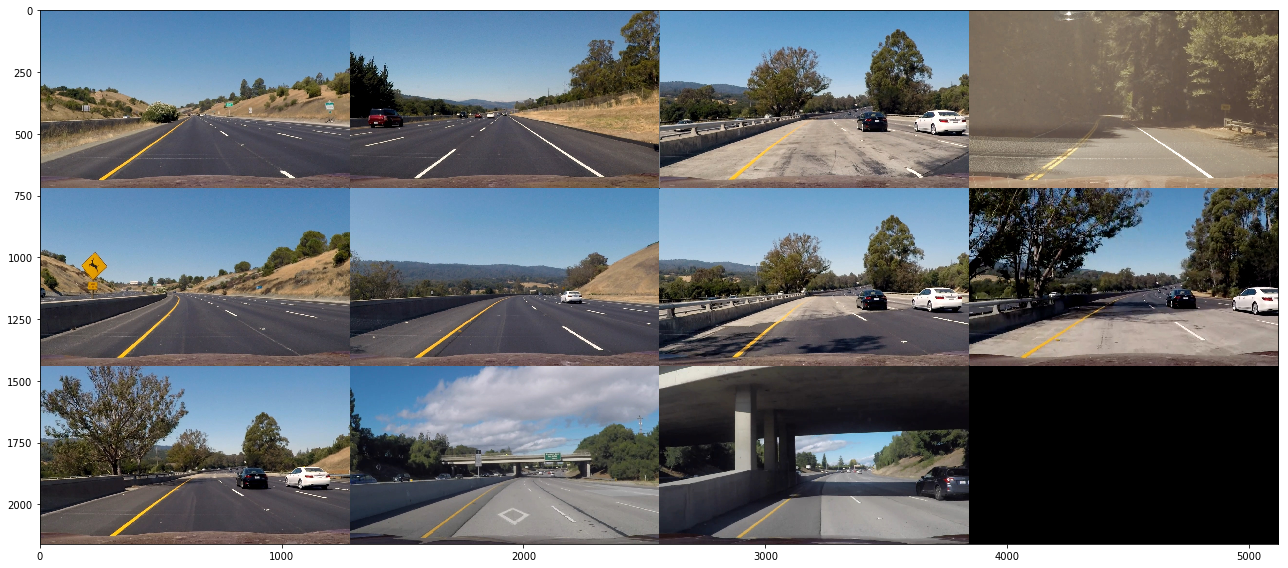

In [107]:
test_imgs = display_imgs(pp.test_imgs, img_num_per_row, img_size, figsize)

## Get undistorted image

input: distorted image 
output: undistorted image

* Undistort the image using cv2.undistort() with mtx and dist
* Define 4 source points (the outer 4 corners detected in the chessboard pattern)
* Define 4 destination points (must be listed in the same order as src points!)
* Use cv2.getPerspectiveTransform() to get M, the transform matrix
* use cv2.warpPerspective() to apply M and warp your image to a top-down view

In [63]:
objpoints = dist_pickle["objpoints"]
imgpoints = dist_pickle["imgpoints"]

undistorted_imgs = []
for i in pp.test_imgs:
    img = cv2.imread(i)
    undistorted_imgs.append(pp.get_undistored_img(img, cc))

row:  4
column:  3


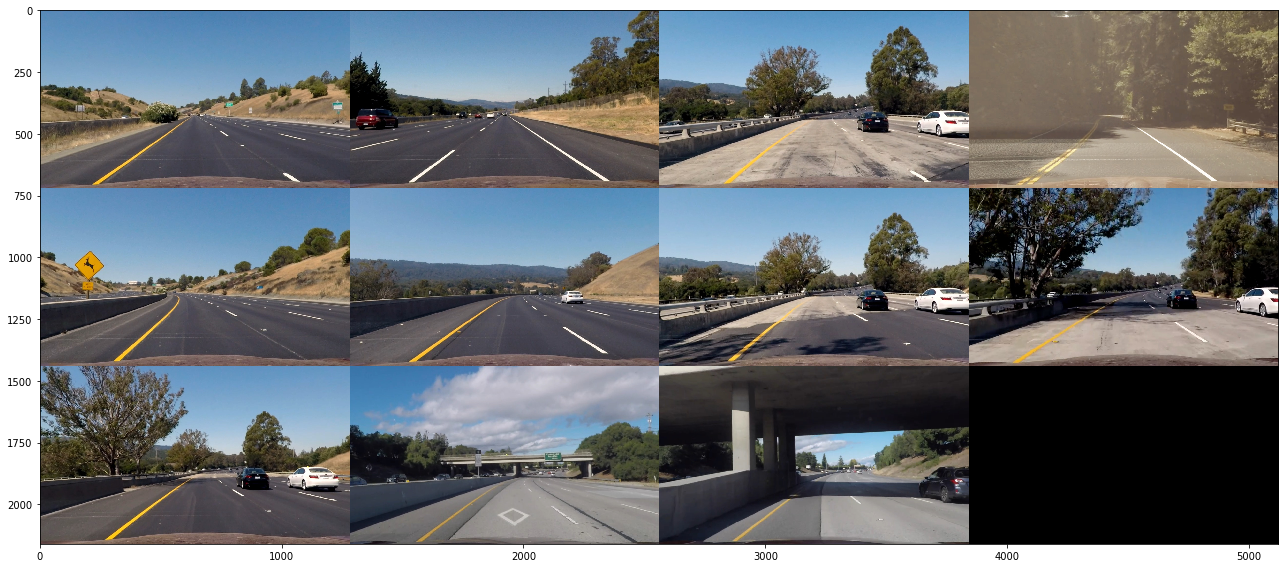

In [64]:
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)

display_undistorted_imgs = display_imgs(undistorted_imgs, img_num_per_row, img_size, figsize, need_read = False)

## Get perspective transformed images

In [68]:
perspective_imgs = []
src_imgs = []
dst_imgs = []
for i in undistorted_imgs:
    perspective_img, src_img, dst_img = pp.perspective_transform(i)
    perspective_imgs.append(perspective_img)
    src_imgs.append(src_img)
    dst_imgs.append(dst_img)

row:  4
column:  3


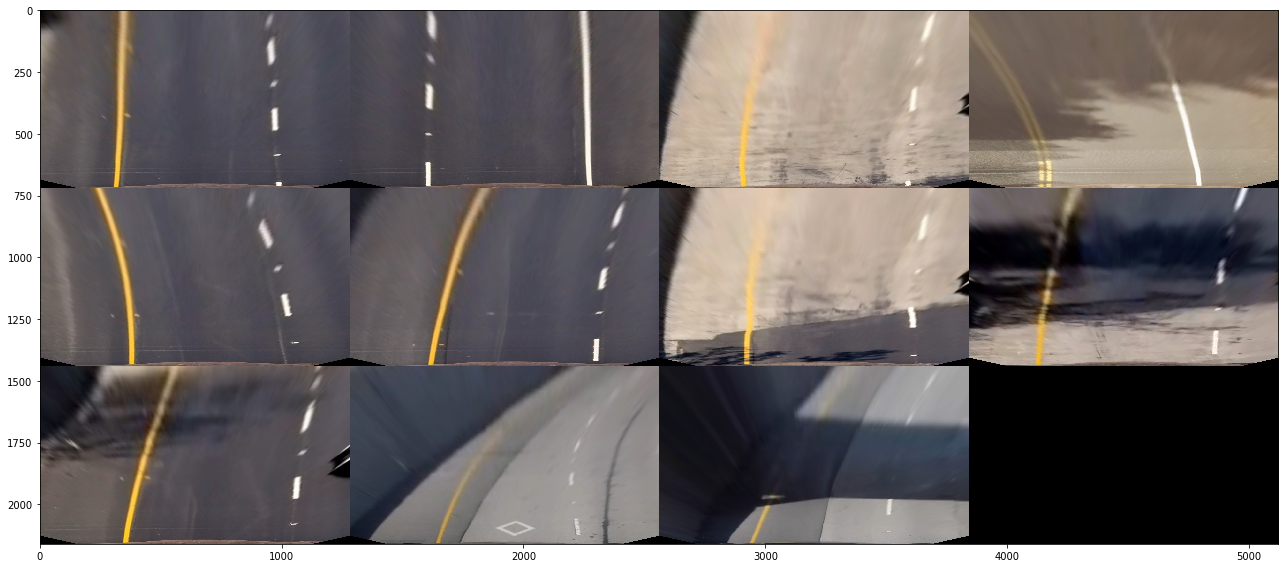

In [71]:
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)

display_perspective_imgs = display_imgs(perspective_imgs, img_num_per_row, img_size, figsize, need_read = False)

In [1053]:
#region of interest
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img, dtype=np.uint8)
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

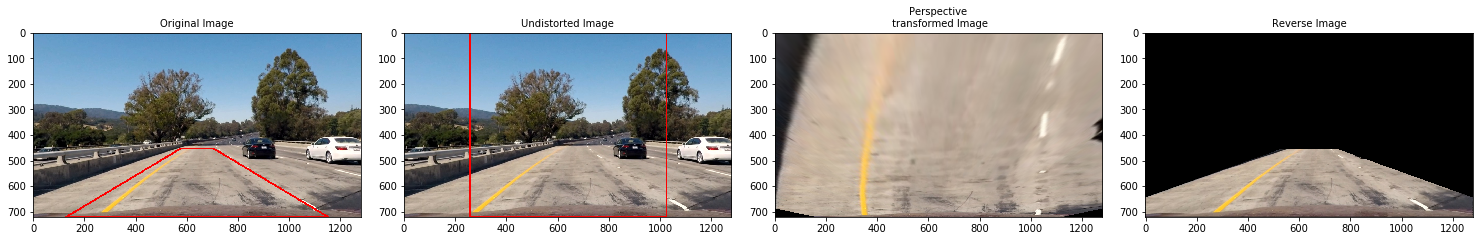

In [1057]:
perspective_img, reverse_perspective_img, Minv, s_img, t_img = perspective_transform(undistorted)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 10))
f.tight_layout()
ax1.imshow(s_img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(t_img)
ax2.set_title('Undistorted Image', fontsize=10)
ax3.imshow(perspective_img)
ax3.set_title('Perspective\n transformed Image', fontsize=10)
ax4.imshow(reverse_perspective_img)
ax4.set_title('Reverse Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Gradient threshold

In [113]:
def display_imgs_1D(imgs, img_num_per_row, img_size, fig_size):
    
    col_num = math.ceil(len(imgs)/img_num_per_row)
    print ("row: ",img_num_per_row)
    print ("column: ",col_num)

    RGB_img = np.zeros((img_size[0] * col_num, img_size[1] * img_num_per_row))

    for i, fname in enumerate(imgs):
        RGB_img[img_size[0] * (i//img_num_per_row):img_size[0] * ((i//img_num_per_row) + 1)
                ,img_size[1] * (i%img_num_per_row):img_size[1] * ((i%img_num_per_row) + 1)] = fname

    RGB_img = np.uint8(RGB_img) 
    
    fig, ax = plt.subplots(figsize=fig_size)
    ax.imshow(RGB_img, aspect='auto', cmap="gray")
    plt.tight_layout()   
    return RGB_img

In [108]:
abs_sobel_imgs = []
for i in perspective_imgs:
    grad_binary = pp.abs_sobel_thresh(i, orient='x', thresh_min=10, thresh_max=70)
    abs_sobel_imgs.append(grad_binary)

row:  4
column:  3


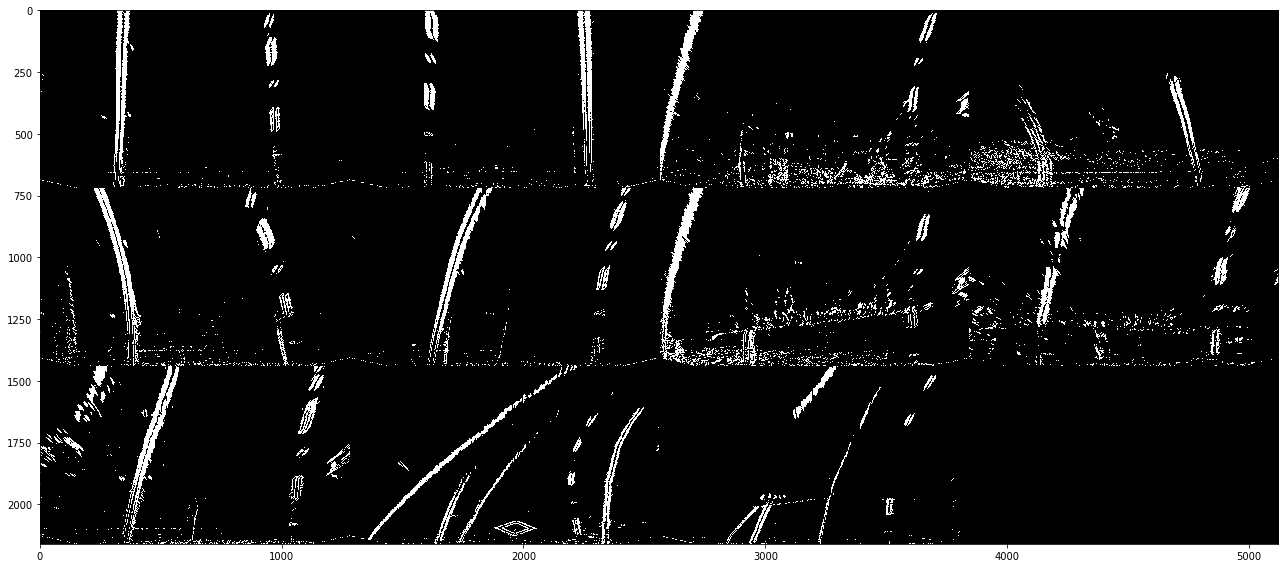

In [114]:
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
display_abs_sobel_imgs = display_imgs_1D(abs_sobel_imgs, img_num_per_row, img_size, figsize)

## Gradient Magnitude threshold

row:  4
column:  3


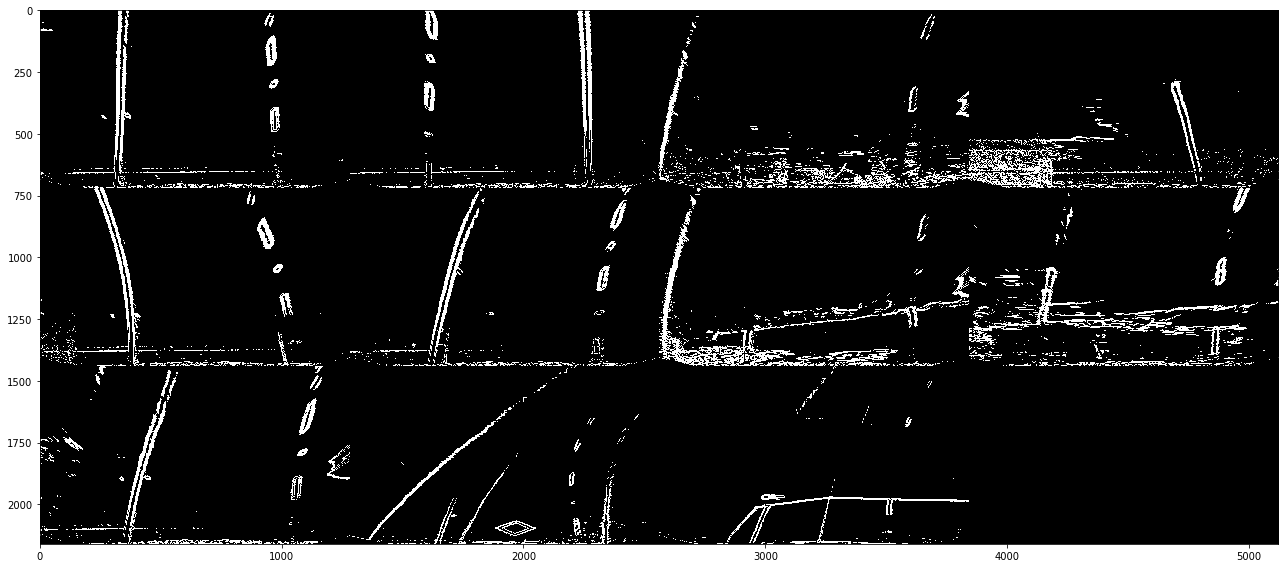

In [119]:
grad_maginitude_imgs = []
for i in perspective_imgs:
    mag_binary = pp.mag_thresh(i, sobel_kernel=9, mag_thresh=(10, 50))
    grad_maginitude_imgs.append(mag_binary)
    
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
display_grad_maginitude_imgs = display_imgs_1D(grad_maginitude_imgs, img_num_per_row, img_size, figsize)

## Direction of the Gradient

arctan2 returns Array of angles in radians, in the range [-pi, pi].

radians = degrees × π / 180°

ref: https://docs.scipy.org/doc/numpy-1.12.0/reference/generated/numpy.arctan2.html

In [349]:
for i in np.arange(0,195,15):
    print ("degree: {} , radian: {}".format(i, i* np.pi/180))

degree: 0 , radian: 0.0
degree: 15 , radian: 0.2617993877991494
degree: 30 , radian: 0.5235987755982988
degree: 45 , radian: 0.7853981633974483
degree: 60 , radian: 1.0471975511965976
degree: 75 , radian: 1.3089969389957472
degree: 90 , radian: 1.5707963267948966
degree: 105 , radian: 1.8325957145940461
degree: 120 , radian: 2.0943951023931953
degree: 135 , radian: 2.356194490192345
degree: 150 , radian: 2.6179938779914944
degree: 165 , radian: 2.8797932657906435
degree: 180 , radian: 3.141592653589793


In [821]:
for i in np.arange(0, 3.14, 0.1):
    new_fname = "..//sobel_images//marked_"+str(i)+".jpg"
    dir_binary = dir_threshold(perspective_img, sobel_kernel=15, thresh=(i, i+0.1))
    plt.imsave(fname = new_fname, arr =dir_binary )

row:  4
column:  3


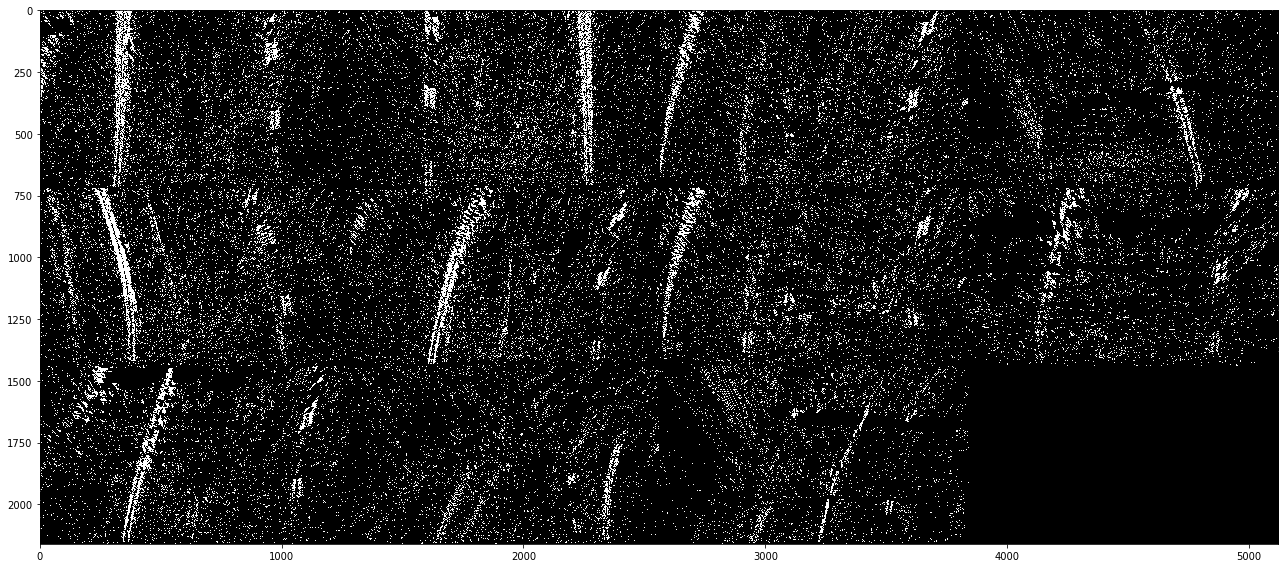

In [132]:
dir_binary_imgs = []
for i in perspective_imgs:
    dir_binary = pp.dir_threshold(i, sobel_kernel=11, thresh=(0.05, 0.4))
    dir_binary_imgs.append(dir_binary)
    
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
display_dir_binary_imgs = display_imgs_1D(dir_binary_imgs, img_num_per_row, img_size, figsize)

## Color thresholding

### HLS

#### example

In [134]:
hls_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HLS)  # cv2.cvtColor(perspective_img, cv2.COLOR_HLS2RGB)
H_img = hls_img[:,:,0]
L_img = hls_img[:,:,1]
S_img = hls_img[:,:,2]

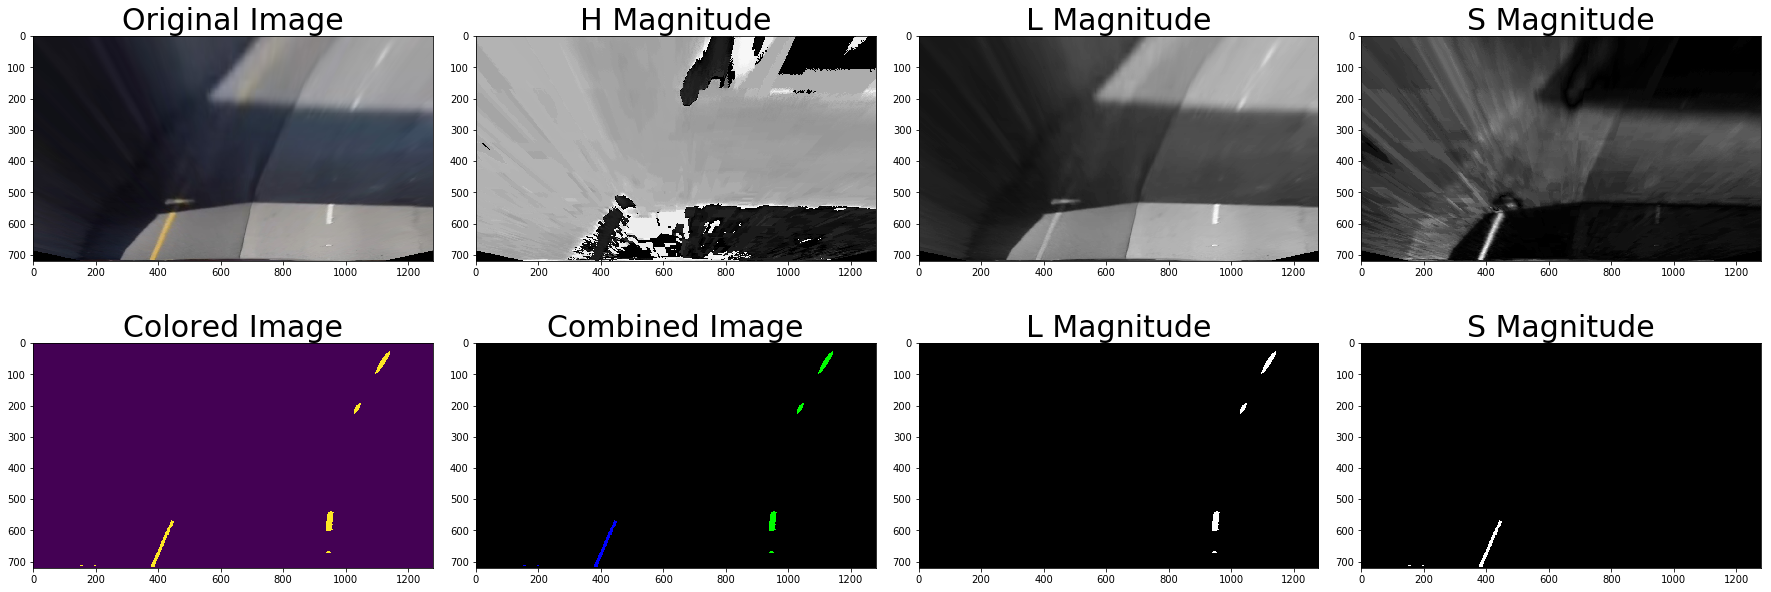

In [147]:
# Plot the result
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()

ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=30)

ax2.imshow(H_img, cmap='gray')
ax2.set_title('H Magnitude', fontsize=30)

ax3.imshow(L_img, cmap='gray')
ax3.set_title('L Magnitude', fontsize=30)

ax4.imshow(S_img, cmap='gray')
ax4.set_title('S Magnitude', fontsize=30)

H_binary = np.zeros_like(H_img)

L_thresh = (180, 255)
L_binary = np.zeros_like(L_img)
L_binary[(L_img > L_thresh[0]) & (L_img <= L_thresh[1])] = 1

S_thresh = (100, 255)
S_binary = np.zeros_like(S_img)
S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

# Sobel x
gray = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 10
thresh_max = 50
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# (1) Combine the two binary thresholds
combined_binary = np.zeros_like(perspective_img[:,:,0])
combined_binary[(L_binary == 1) | (S_binary == 1) | (sxbinary == 1)] = 255

# (2) Colored combined image
filtered_hls_img = np.stack((H_binary, L_binary, S_binary), axis=2) *255

# (3)
lower_HLS = np.array([15, 150, 100])
upper_HLS = np.array([30, 255, 255])
mask_HLS = cv2.inRange(hls_img, lower_HLS, upper_HLS)
mask_HLS_img = cv2.bitwise_and(hls_img,hls_img, mask= mask_HLS)

ax5.imshow(combined_binary);ax5.set_title('Colored Image', fontsize=30);
ax6.imshow(filtered_hls_img);ax6.set_title('Combined Image', fontsize=30);
ax7.imshow(L_binary, cmap='gray');ax7.set_title('L Magnitude', fontsize=30);
ax8.imshow(S_binary, cmap='gray');ax8.set_title('S Magnitude', fontsize=30);plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### multiple thresholds

row:  4
column:  3


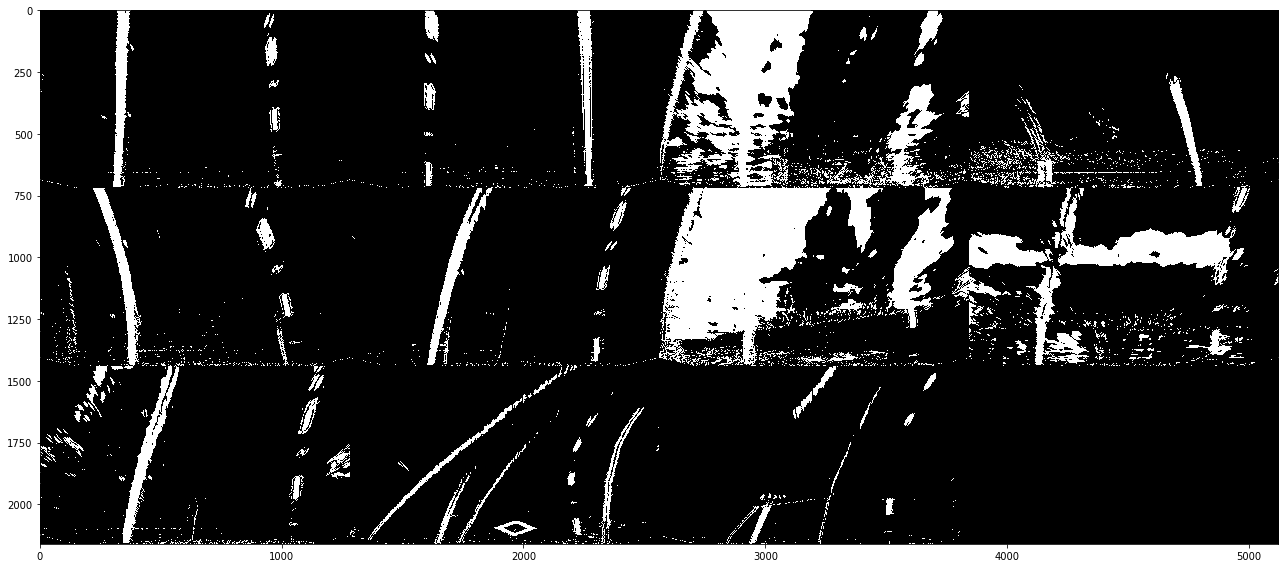

In [164]:
HLS_imgs = []
for i in perspective_imgs:
    HLS_img = pp.HLS_color_thresh(i)
    HLS_imgs.append(HLS_img)
    
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
display_HLS_imgs = display_imgs_1D(HLS_imgs, img_num_per_row, img_size, figsize)

### HSV

For HSV, Hue range is [0,179], Saturation range is [0,255] and Value range is [0,255].

#### example

In [149]:
hsv_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HSV)  # cv2.cvtColor(perspective_img, cv2.COLOR_HSV2RGB)
H_img = hsv_img[:,:,0]
S_img = hsv_img[:,:,1]
V_img = hsv_img[:,:,2]

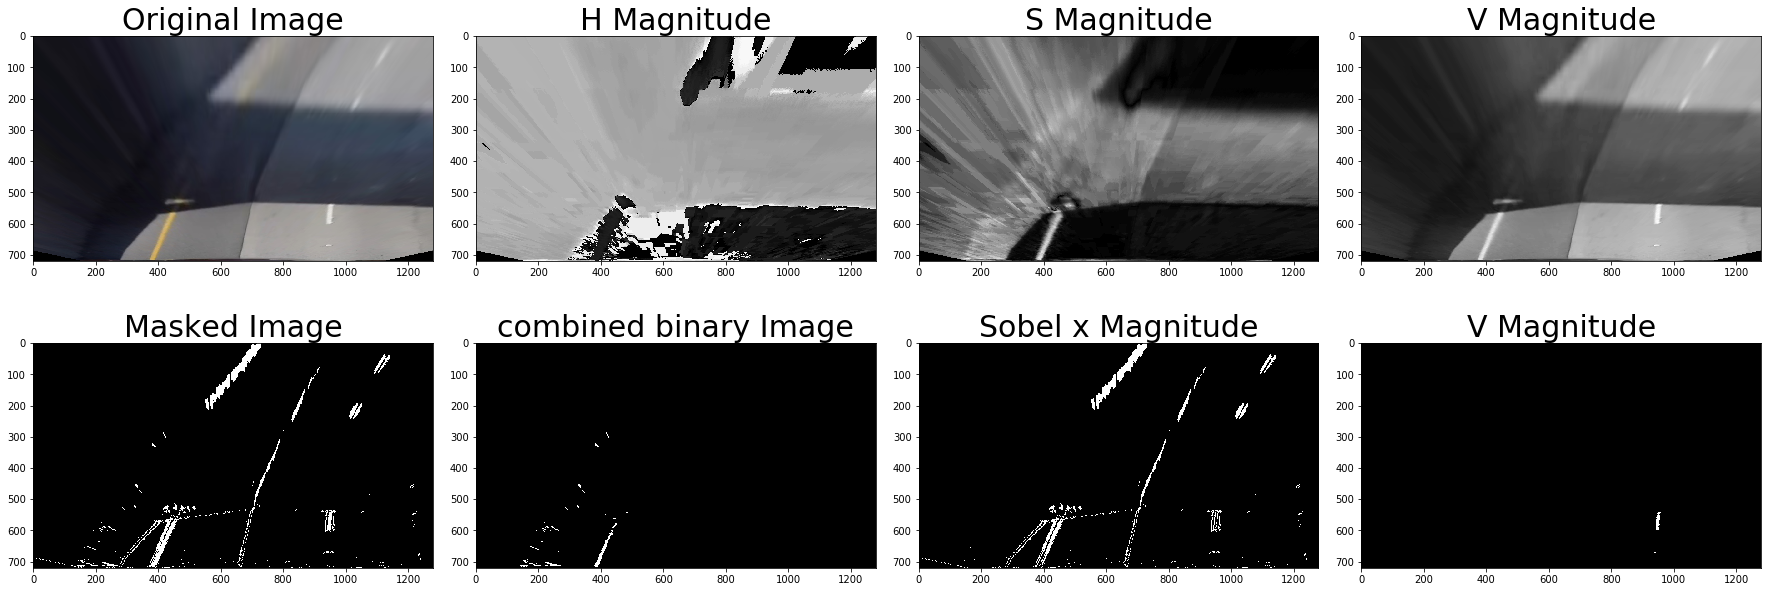

In [160]:
# Run the function
mag_binary = mag_thresh(perspective_img, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(H_img, cmap='gray')
ax2.set_title('H Magnitude', fontsize=30)
ax3.imshow(S_img, cmap='gray')
ax3.set_title('S Magnitude', fontsize=30)
ax4.imshow(V_img, cmap='gray')
ax4.set_title('V Magnitude', fontsize=30)

hsv_img = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2HSV)  # cv2.cvtColor(perspective_img, cv2.COLOR_HSV2RGB)

# Sobel x
gray = cv2.cvtColor(perspective_img, cv2.COLOR_RGB2GRAY)
sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# Threshold x gradient
thresh_min = 10
thresh_max = 40
sxbinary = np.zeros_like(scaled_sobel)
sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

H_binary = np.zeros_like(H_img)

S_thresh = (120, 200)
S_binary = np.zeros_like(S_img)
S_binary[(S_img > S_thresh[0]) & (S_img <= S_thresh[1])] = 1

V_thresh = (220, 255)
V_binary = np.zeros_like(V_img)
V_binary[(V_img > V_thresh[0]) & (V_img <= V_thresh[1])] = 1

# (1) Combine the two binary thresholds
combined_binary = np.zeros_like(perspective_img[:,:,0])
combined_binary[(S_binary == 1) | (V_binary == 1) | (sxbinary == 1)] = 1

# (2) Colored combined image
filtered_hls_img = np.stack((H_binary, S_binary, V_binary), axis=2)

# (3)
lower_HSV = np.array([1, 1, 220])
upper_HSV = np.array([179, 255, 255])
mask_HSV = cv2.inRange(hsv_img, lower_HSV, upper_HSV)
mask_HSV_img = cv2.bitwise_and(hsv_img,hsv_img, mask= mask_HSV)


ax5.imshow(combined_binary*255, cmap='gray');ax5.set_title('Masked Image', fontsize=30);
ax6.imshow(S_binary, cmap='gray');ax6.set_title('combined binary Image', fontsize=30);
ax7.imshow(sxbinary, cmap='gray');ax7.set_title('Sobel x Magnitude', fontsize=30);
ax8.imshow(V_binary, cmap='gray');ax8.set_title('V Magnitude', fontsize=30);plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

#### multiple threshold

row:  4
column:  3


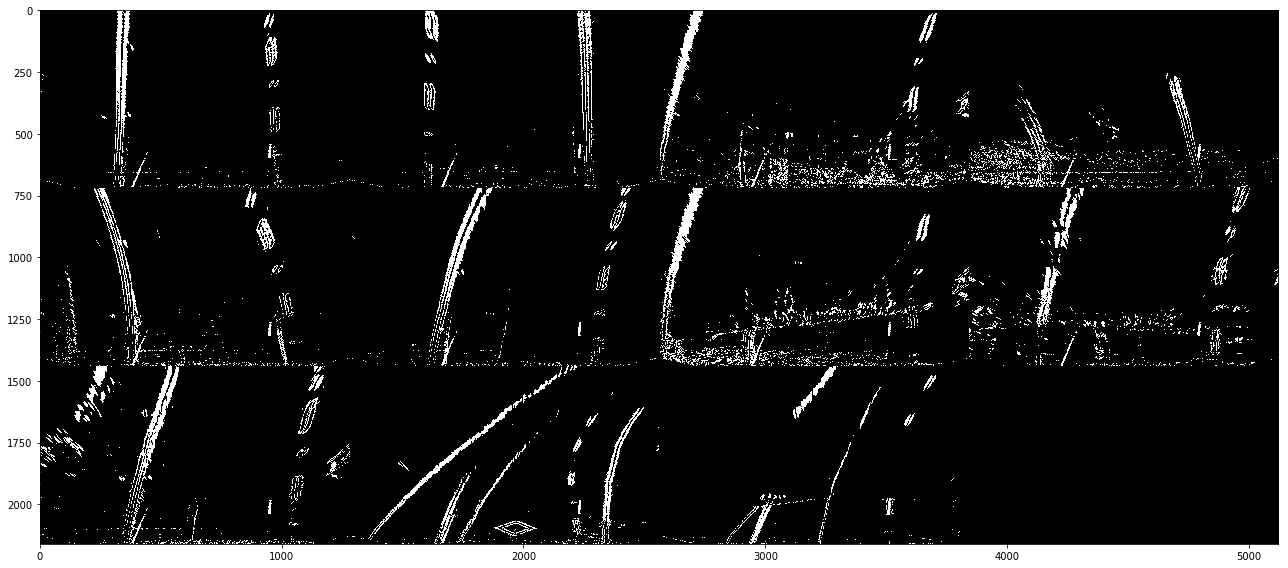

In [170]:
HSV_imgs = []
for i in perspective_imgs:
    HSV_img = pp.HSV_color_thresh(i)
    HSV_imgs.append(HSV_img)
    
figsize=(18, 8)
img_num_per_row = 4
img_size = (720,1280)
display_HSV_imgs = display_imgs_1D(HSV_imgs, img_num_per_row, img_size, figsize)

## Line Finding Method: Peaks in a Histogram

In [219]:
def gaussian_blur(img, kernel_size):
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def FindPeaks_Histogram(img, gaussian = False, kernel_size = 7):
    if gaussian:
        img = gaussian_blur(img, kernel_size)
    combined_histogram = np.sum(img[int(img.shape[0]*0.5):,:], axis=0)
    
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    f.tight_layout()
    ax1.imshow(img, cmap='gray')
    ax1.set_title('gaussian blur combined binary', fontsize=10)
    ax2.plot(combined_histogram)
    ax2.set_title('gaussian blur histogram', fontsize=10)

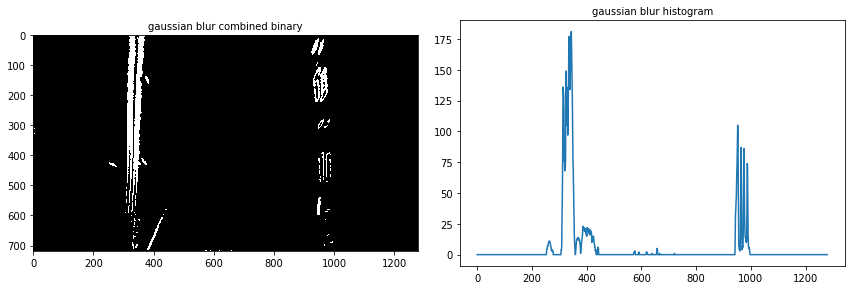

In [220]:
FindPeaks_Histogram(HSV_imgs[0], True, 9)

## sliding window

In [262]:
def fit_line_with_sliding_window(binary_warped, visualization=True):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = histogram.shape[0]//2
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # visualization of sliding window
    if visualization:
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    return left_fit, right_fit, out_img

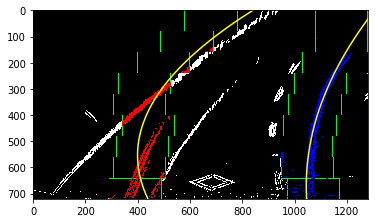

In [263]:
left_fit, right_fit, out_img = fit_line_with_sliding_window(HSV_imgs[9], visualization=True)

### visualize without sliding window

In [244]:
def fit_line_without_sliding_window(binary_warped, left_fit, right_fit, visualization=True):

    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)

The green shaded area shows where to search for the lines this time. 
Once you know where the lines are in one frame of video, you can do a highly targeted search for them in the next frame. This is equivalent to using a **customized region of interest** for each frame of video, and should help you track the lanes through sharp curves and tricky conditions. If you lose track of the lines, go back to the **sliding windows search** or other method (convolution for maximizing the number of "hot" pixels in each window.) to rediscover them.

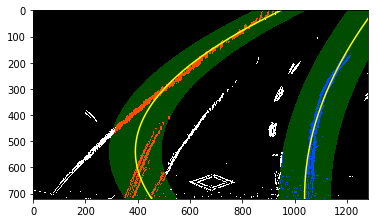

In [245]:
fit_line_without_sliding_window(HSV_imgs[9], left_fit, right_fit, visualization=True)

### curvature calculation
ref: https://www.intmath.com/applications-differentiation/8-radius-curvature.php

In [253]:
# Define y-value where we want radius of curvature
# I'll choose the maximum y-value, corresponding to the bottom of the image
y_eval = np.max(ploty)
left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
print(left_curverad, right_curverad)
# Example values: 1926.74 1908.48

1652.57212235 1838.87652008


### converting x and y values to real world space.

The images with U.S. regulations that require a minimum lane width of 12 feet or 3.7 meters, and the dashed lane lines are 10 feet or 3 meters long each.

ref: http://onlinemanuals.txdot.gov/txdotmanuals/rdw/horizontal_alignment.htm#BGBHGEGC

In [255]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
# Example values: 632.1 m    626.2 m

542.792574687 m 603.783366349 m


In [ ]:
### convolution for hot pixel

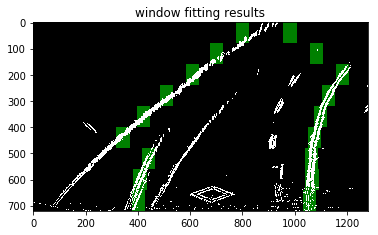

In [256]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import cv2

# Read in a thresholded image
warped = HSV_imgs[9]
# window settings
window_width = 50 
window_height = 80 # Break image into 9 vertical layers since image height is 720
margin = 100 # How much to slide left and right for searching

def window_mask(width, height, img_ref, center,level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output

def find_window_centroids(image, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(image[int(3*image.shape[0]/4):,:int(image.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(image[int(3*image.shape[0]/4):,int(image.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(image.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(image.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(image[int(image.shape[0]-(level+1)*window_height):int(image.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,image.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,image.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids

window_centroids = find_window_centroids(warped, window_width, window_height, margin)

# If we found any window centers
if len(window_centroids) > 0:

    # Points used to draw all the left and right windows
    l_points = np.zeros_like(warped)
    r_points = np.zeros_like(warped)

    # Go through each level and draw the windows 	
    for level in range(0,len(window_centroids)):
        # Window_mask is a function to draw window areas
	    l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
	    r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
	    # Add graphic points from window mask here to total pixels found 
	    l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
	    r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

    # Draw the results
    template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
    zero_channel = np.zeros_like(template) # create a zero color channel
    template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
    warpage= np.dstack((warped, warped, warped))*255 # making the original road pixels 3 color channels
    output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
 
   
else:  # If no window centers found, just display orginal road image
    output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

# Display the final results
plt.imshow(output)
plt.title('window fitting results')
plt.show()

## Video processing

TypeError: Image data cannot be converted to float

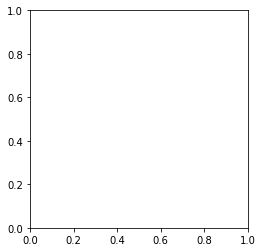

In [270]:
plt.imshow(out_image)

Processing video: ..//test_videos\project_video.mp4


TypeError: image is not a numerical tuple

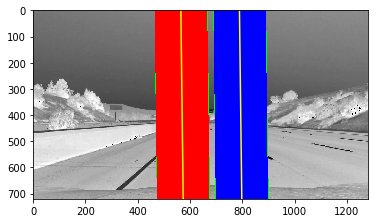

In [271]:
test_videos_dir = '..//test_videos'
test_videos = [os.path.join(test_videos_dir, name) for name in os.listdir(test_videos_dir)]
for test_video in test_videos:
    print('Processing video: {}'.format(test_video))
    cap = cv2.VideoCapture(test_video)  
    
    # get video frame size
    width, height = 0, 0
    if cap.isOpened(): 
        width = int(cap.get(3))
        height = int(cap.get(4)) 

    # initialize video writer object
    out_Video = cv2.VideoWriter(os.path.join('..//test_video_output', "prospective_" + os.path.basename(test_video)),
                      fourcc=cv2.VideoWriter_fourcc(*'DIVX'),
                      fps=24.0, frameSize=(width, height))
    in_image = None
    try:
        while cap.isOpened():
            # cap.read() returns a bool (True/False). 
            # If frame is read correctly, it will be True. 
            # End of the video can be checked with this return value.
            ret, color_frame = cap.read()
            if ret:
                in_image = cv2.cvtColor(color_frame, cv2.COLOR_BGR2RGB)
                in_image_cp = np.copy(in_image)
                in_image_cp = cv2.cvtColor(in_image_cp, cv2.COLOR_RGB2GRAY)
                out_image = fit_line_with_sliding_window(in_image_cp, visualization=True)
                out_Video.write(out_image)     
                
#                 out_Video.write(cv2.cvtColor(out_image, cv2.COLOR_RGB2BGR))     
            else:
                break
        print ("transform ends")        
    finally:
        cap.release()
        out_Video.release()
        cv2.destroyAllWindows()

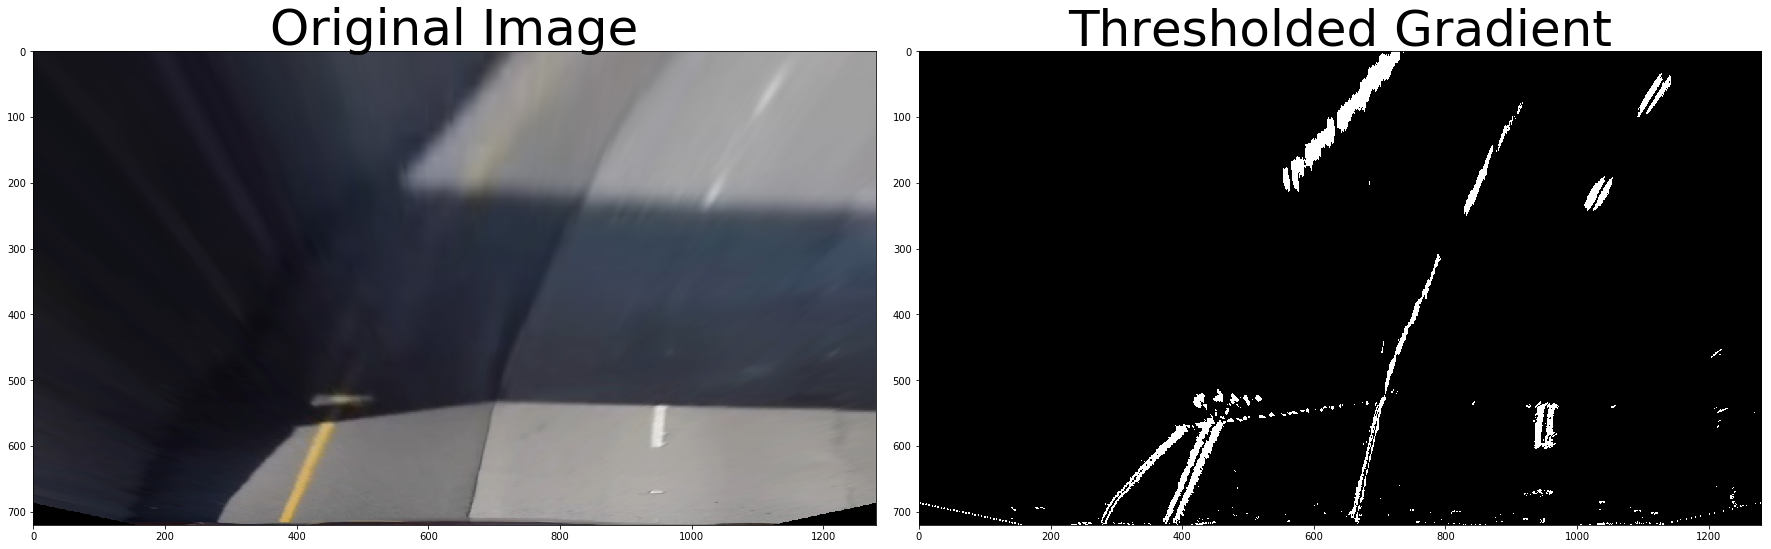

In [115]:
# Run the function
grad_binary = abs_sobel_thresh(perspective_img, orient='x', thresh_min=10, thresh_max=70)
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

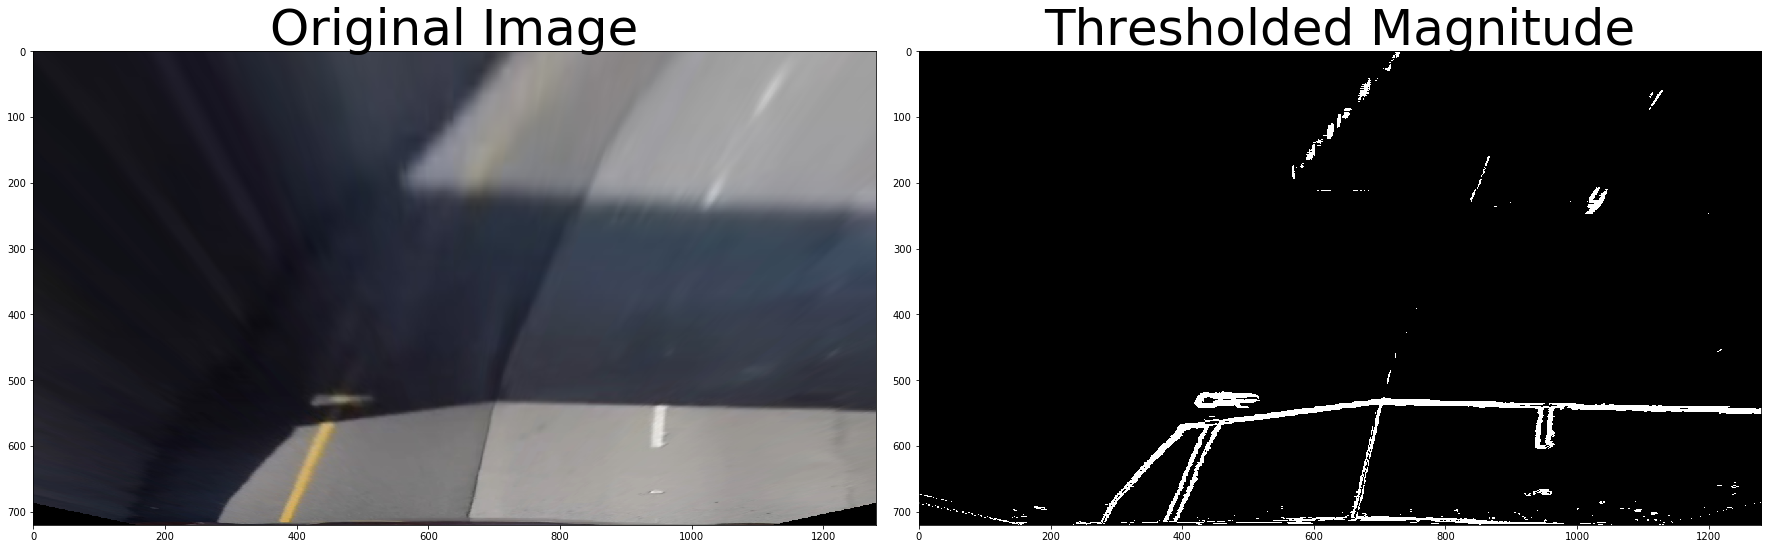

In [116]:
# Run the function
mag_binary = mag_thresh(perspective_img, sobel_kernel=9, mag_thresh=(10, 50))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

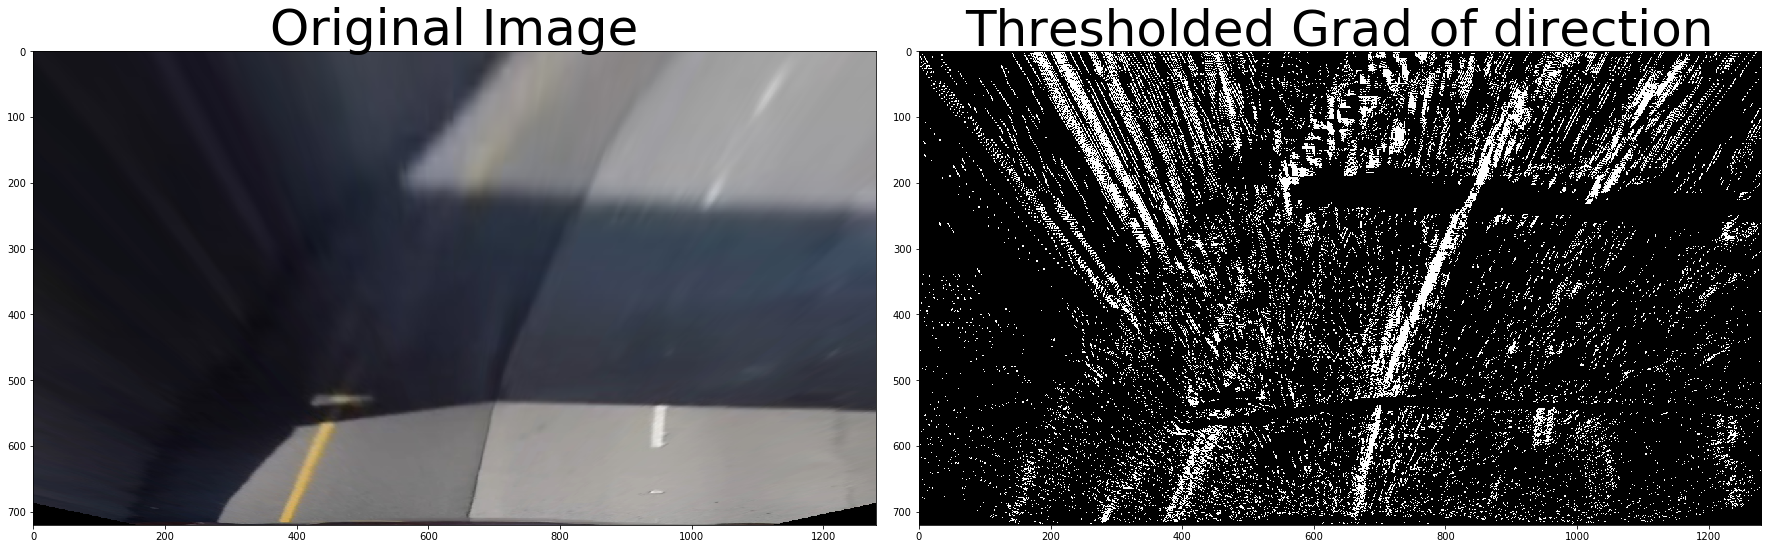

In [117]:
# Run the function
dir_binary = dir_threshold(perspective_img, sobel_kernel=15, thresh=(0.1, 0.6))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(perspective_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad of direction', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## simulation

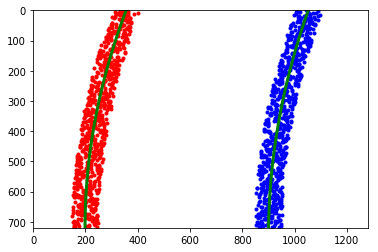

In [252]:
# Generate some fake data to represent lane-line pixels
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
quadratic_coeff = 3e-4 # arbitrary quadratic coefficient
# For each y position generate random x position within +/-50 pix
# of the line base position in each case (x=200 for left, and x=900 for right)
leftx = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                              for y in ploty])
rightx = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) 
                                for y in ploty])

leftx = leftx[::-1]  # Reverse to match top-to-bottom in y
rightx = rightx[::-1]  # Reverse to match top-to-bottom in y


# Fit a second order polynomial to pixel positions in each fake lane line
left_fit = np.polyfit(ploty, leftx, 2)
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fit = np.polyfit(ploty, rightx, 2)
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Plot up the fake data
mark_size = 3
plt.plot(leftx, ploty, 'o', color='red', markersize=mark_size)
plt.plot(rightx, ploty, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fitx, ploty, color='green', linewidth=3)
plt.plot(right_fitx, ploty, color='green', linewidth=3)
plt.gca().invert_yaxis() # to visualize as we do the images